In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:,2:]
y = iris.target

In [2]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

决策树可视化：使用export_graphviz()

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file='./dot_images/iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

1. 使用Graphviz软件包中的dot命令行工具将此.dot文件转换为多种格式，例如PDF或PNG[1]
2. ❯ dot -Tpng ./dot_images/iris_tree.dot -o ./output_images/iris_tree.png
    - <image src="./output_images/iris_tree.png" width=600 height=400>
3. 节点的samples属性统计它应用的训练实例数量。例如，有100个训练实例的花瓣长度大于2.45cm（深度1，右）​，其中54个花瓣宽度小于1.75cm（深度2，左）​。
4. 节点的value属性说明了该节点上每个类别的训练实例数量。例如，右下节点应用在0个山鸢尾、1个变色鸢尾和45个维吉尼亚鸢尾实例上
5. 节点的gini属性衡量其不纯度（impurity）​：如果应用的所有训练实例都属于同一个类别，那么节点就是“纯”的（gini=0）​。
    - 第i个节点的基尼系数Gi的计算方式。例如，深度2左侧节点，基尼系数等于1–（0/54）2–（49/54）2–（5/54）2≈0.168。
6. Scikit-Learn使用的是CART算法，该算法仅生成二叉树：非叶节点永远只有**两个**子节点（即问题答案仅有是或否）​。但是，其他算法（比如ID3生成的决策树）​，其节点可以拥有两个以上的子节点。

#### 做出预测
1. 决策树的许多特质之一就是它们几乎不需要数据准备。实际上，它们根本不需要特征缩放或居中。
2. 决策树是直观的，其决策也易于解释。这种模型通常称为白盒模型。相反，正如我们将看到的，通常将随机森林或神经网络视为黑盒模型。

Text(4.05, 0.5, '(Depth=2)')

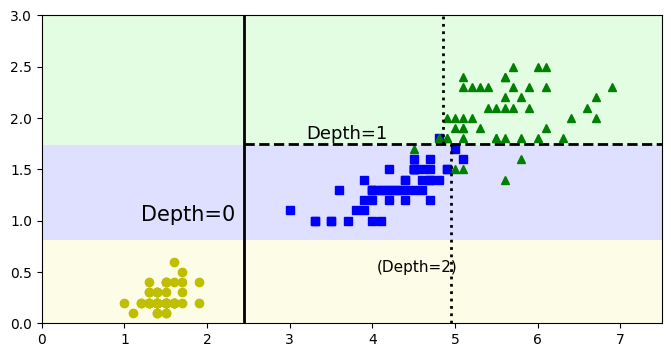

In [5]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[0,7.5,0,3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred,alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1,x2,y_pred,cmap=custom_cmap2)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.20, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

#### 估计类概率
1. 决策树同样可以估算某个实例属于特定类k的概率，然后返回该节点中类k的训练实例占比

In [6]:
print(tree_clf.predict_proba([[5,1.5]]))
print(tree_clf.predict([[5,1.5]]))

[[0.         0.90740741 0.09259259]]
[1]


#### CART训练算法（Classificationand Regression Tree，CART）
1. 该算法的工作原理是：首先使用单个特征k和阈值tk（例如，​“花瓣长度”≤2.45cm”​）将训练集分为两个子集。如何选择k和tk？它搜索产生最纯子集（按其大小加权）的一对（k，tk）​。公式6-2给出了算法试图最小化的成本函数。
    - <img src="./images/CART算法成本函数.png" width=800 height=200>

2. 一旦CART算法成功地将训练集分为两部分，它就会使用相同的逻辑将子集进行分割，然后再分割子集，以此类推。一旦达到最大深度（由超参数max_depth定义）​，或者找不到可减少不纯度的分割，它将停止递归。其他一些超参数（稍后描述）可以控制其他一些停止条件 (min_samples_split、min_samples_leaf、min_weight_fraction_leaf和max_leaf_nodes)

3. CART是一种贪婪算法：从顶层开始搜索最优分裂，然后每层重复这个过程。几层分裂之后，它并不会检视这个分裂的不纯度是否为可能的最低值。贪婪算法通常会产生一个相当不错的解，但是**不能保证是最优解**。


#### 计算复杂度
1. **进行预测**需要从根到叶遍历决策树,决策树通常是近似平衡的，因此遍历决策树需要经过大约O（log2（m）​）个节点,由于每个节点仅需要检查一个特征值，因此总体预测复杂度为O（log2（m）​）​。与特征数量无关。因此，即使处理大训练集，预测也非常快。
2. 训练算法比较每个节点上所有样本上的所有特征（如果设置了max_features，则更少）​。比较每个节点上所有样本的所有特征会导致训练复杂度为O（n×m log2（m）​）​。

#### 基尼不纯度或熵
1. 默认使用的是基尼不纯度来进行测量，但是，你可以将超参数criterion设置为"entropy"来选择熵作为不纯度的测量方式。
2. 那么到底应该使用基尼不纯度还是熵呢？其实，大多数情况下，它们并没有什么大的不同，产生的树都很相似。基尼不纯度的计算速度略微快一些，所以它是个不错的默认选择。它们的不同在于，基尼不纯度倾向于从树枝中分裂出最常见的类别，而熵则倾向于生产更平衡的树[2](https://homl.info/19)

#### 正则化超参数
1. 决策树极少对训练数据做出假设（比如线性模型就正好相反，它显然假设数据是线性的）​。如果不加以限制，**树的结构将跟随训练集变化**，严密拟合，并且很可能过拟合，这种模型通常被称为非参数模型
2. 为避免过拟合，需要在训练过程中降低决策树的自由度，正则化超参数的选择取决于使用的模型，但是通常来说，至少可以**限制决策树的最大深度**
3. DecisionTreeClassifier类还有一些其他的参数，同样可以限制决策树的形状：
    - min_samples_split（分裂前节点必须有的最小样本数）​
    - min_samples_leaf（叶节点必须有的最小样本数量）​
    - min_weight_fraction_leaf（与min_samples_leaf一样，但表现为加权实例总数的占比）​
    - max_leaf_nodes（最大叶节点数量
    - max_features（分裂每个节点评估的最大特征数量
4. 还可以先不加约束地训练模型，然后再对不必要的节点进行剪枝（删除）​。

Text(0, 0.5, '')

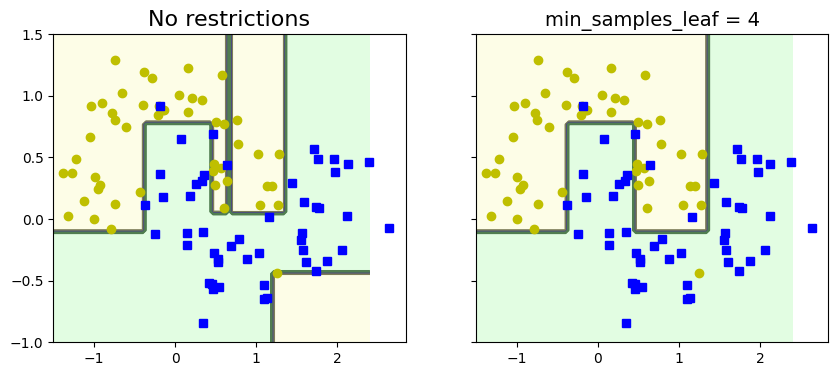

In [7]:
from sklearn.datasets import make_moons
# make_moons函数生成一个月牙形状的数据集
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

# 创建一个包含两个子图的画布，设置画布大小为10x4，并共享y轴。
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title('No restrictions', fontsize=16)

plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title(f'min_samples_leaf = {deep_tree_clf2.min_samples_leaf}', fontsize=14)
plt.ylabel('')




#### 回归

In [8]:
np.random.seed(42)
m = 200
X = np.random.rand(m,1)
y = 4 * (X-0.5) ** 2
y = y + np.random.randn(m,1) / 10

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [10]:
export_graphviz(
    tree_reg,
    out_file='./dot_images/random_tree_reg.dot',
    rounded=True,
    filled=True
)

1. 这棵树看起来与之前建立的分类树很相似。主要差别在于，每个节点上不再预测一个类别而是预测一个值。
2. 例如，如果你想要对一个x1=0.6的新实例进行预测，那么从根节点开始遍历，最后到达预测value=0.111的叶节点。这个预测结果其实就是与这个叶节点关联的110个实例的平均目标值。在这110个实例上，预测产生的均方误差（MSE）等于0.015。
    - <img src='./output_images/random_tree_reg.png'>

3. 注意看，每个区域的预测值永远等于该区域内实例的目标平均值。算法分裂每个区域的方法就是使最多的训练实例尽可能接近这个预测值
4. 就像分类任务一样，决策树在处理回归任务时容易过拟合

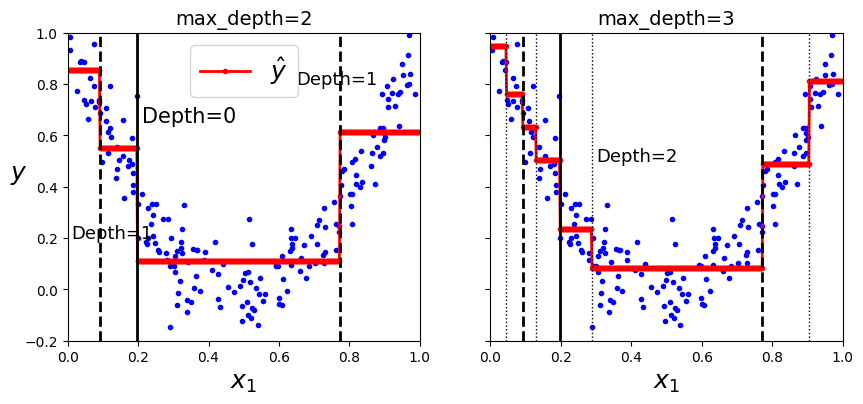

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0,1,-0.2,1], ylabel='$y$'):
    x1 = np.linspace(axes[0],axes[1], 500).reshape(-1,1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$",fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")
    
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

#### 不稳定性
1. 决策树喜欢正交的决策边界（所有分割都垂直于轴）​，这使它们对**训练集旋转**敏感。
2. 尽管两个决策树都非常拟合训练集，但右侧的模型可能无法很好地泛化。限制此问题的一种方法是使用主成分分析
3. 决策树的主要问题是它们对训练数据中的小变化非常敏感,随机森林可以通过对许多树进行平均预测来限制这种不稳定性

Text(0, 0.5, '')

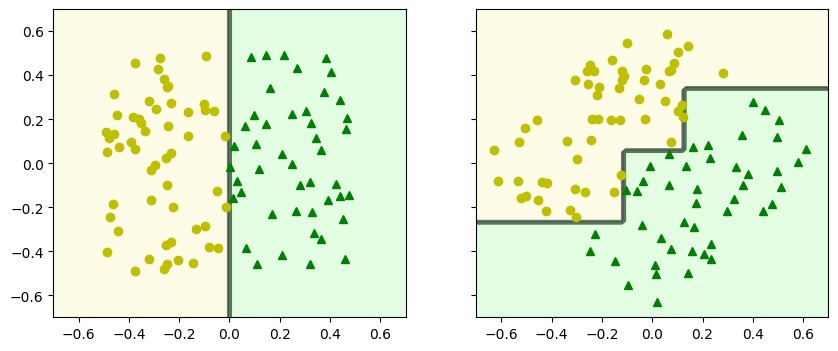

In [12]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")


#### 练习题
1. 如果训练集有100万个实例，训练决策树（无约束）大致的深度是多少
 - 如果训练集包含100万个实例，那么决策树的深度为log2（106）≈20层（实际上会更多一些，因为决策树通常不可能完美平衡

2. 通常来说，子节点的基尼不纯度是高于还是低于其父节点？是通常更高/更低？还是永远更高/更低？
 - 低于父节点，通常是更低

3. 如果决策树过拟合训练集，减少max_depth是否为一个好主意
 - 是的

4. 如果决策树对训练集欠拟合，尝试缩放输入特征是否为一个好主意
 - 不是，决策树对特征的量级和单位不敏感

5. 如果在包含100万个实例的训练集上训练决策树需要一个小时，那么在包含1000万个实例的训练集上训练决策树，大概需要多长时间？
 - 决策树的训练复杂度为O（n×mlog（m）​）​所以，如果将训练集大小乘以10，训练时间将乘以K=（n×10m×log（10m）​）/（n×m×log（m）​）=10×log（10m）/log（m）​。如果m=106，那么K≈11.7，所以训练1000万个实例大约需要11.7小时。

6. 如果训练集包含10万个实例，设置presort=True可以加快训练吗？
 - 不可以


In [16]:
#  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tree_clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_leaf_nodes': list(range(2, 100)),
    'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(tree_clf,param_grid=param_grid,verbose=1, cv=3)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [17]:
grid_search.best_params_

{'max_leaf_nodes': 29, 'min_samples_split': 2}

In [18]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.86

In [ ]:
# # 练习题8
# from sklearn.model_selection import ShuffleSplit
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from scipy import stats

# rs = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# for i, (train_index, test_index) in enumerate(rs.split(X)):
#     X_train_fold = X[train_index]
#     y_train_fold = y[train_index]
#     X_test_fold = X[test_index]
#     y_test_fold = y[test_index]
    
#     tree_clf = DecisionTreeClassifier(max_leaf_nodes=29, min_samples_split=2)
    
#     tree_clf.fit(X_train_fold, y_train_fold)
    
#     y_pred_fold = tree_clf.predict(y_test_fold)
#     accuracy_score(y_test_fold, y_pred_fold)
    
#     y_pred_frequent = stats.mode(y_pred_fold)
    

In [22]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [23]:
from sklearn.base import clone

forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.790024

In [24]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [25]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

/tmp/ipykernel_11180/2539803968.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


In [26]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.865